# Plot prediction curve

In [276]:
import torch
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from joblib import dump, load

In [277]:
W=35
L=10
T=25
full_df = pd.read_csv('../data/W35L10T25.csv')
full_df.head()

,Vds,Vgs,Ids,W,L,T
0,0.1,-20.0,2.628500e-13,35,10,25
1,0.1,-19.8,2.628500e-13,35,10,25
2,0.1,-19.6,2.628500e-13,35,10,25
3,0.1,-19.4,2.628500e-13,35,10,25
4,0.1,-19.2,2.628500e-13,35,10,25


In [278]:
vgs_list = full_df['Vgs'].unique()
len(vgs_list)

201

In [279]:
vds_list = full_df['Vds'].unique()
len(vds_list)

6

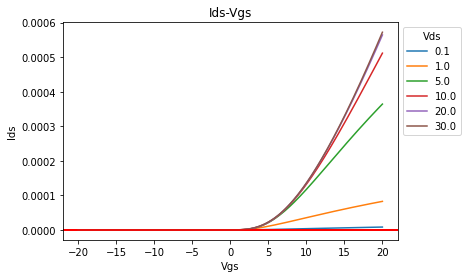

In [280]:
for vds in vds_list:
    plt.plot(full_df.query('Vds=='+str(vds))['Vgs'], full_df.query('Vds=='+str(vds))['Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('Ids')
    plt.axhline(y = 1e-8*W/L, color = 'r', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Ids-Vgs')

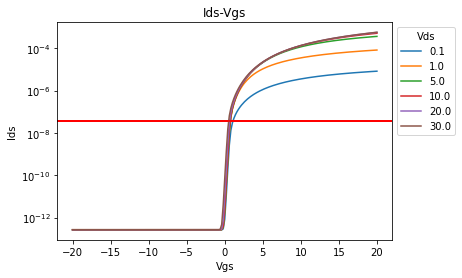

In [281]:
for vds in vds_list:
    plt.plot(full_df.query('Vds=='+str(vds))['Vgs'], full_df.query('Vds=='+str(vds))['Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('Ids')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'r', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Ids-Vgs')

In [282]:
vt_model = xgboost.XGBRegressor()
vt_model.load_model('../checkpoint/vt_xgboost_model.model')

In [283]:
full_df['Vt'] = full_df.apply(lambda row : vt_model.predict([row[['W','L', 'T','Vds']].to_numpy()])[0], axis=1)
full_df.head()

,Vds,Vgs,Ids,W,L,T,Vt
0,0.1,-20.0,2.628500e-13,35,10,25,1.000042
1,0.1,-19.8,2.628500e-13,35,10,25,1.000042
2,0.1,-19.6,2.628500e-13,35,10,25,1.000042
3,0.1,-19.4,2.628500e-13,35,10,25,1.000042
4,0.1,-19.2,2.628500e-13,35,10,25,1.000042


In [284]:
def calculate_drain_equation(width, length, vgs, vds, vt):
    right_term = (vgs-vt)*vds - 1/2*(vds**2)
    return (width/length)*right_term

In [285]:
full_df['Drain'] = full_df.apply(lambda row : calculate_drain_equation(row['W'], row['L'], row['Vgs'], row['Vds'], row['Vt']), axis=1)
full_df.head()

,Vds,Vgs,Ids,W,L,T,Vt,Drain
0,0.1,-20.0,2.628500e-13,35,10,25,1.000042,-7.367515
1,0.1,-19.8,2.628500e-13,35,10,25,1.000042,-7.297515
2,0.1,-19.6,2.628500e-13,35,10,25,1.000042,-7.227515
3,0.1,-19.4,2.628500e-13,35,10,25,1.000042,-7.157515
4,0.1,-19.2,2.628500e-13,35,10,25,1.000042,-7.087515


In [286]:
class_0_df = full_df.query('Vgs<0')
class_1_df = full_df.query('Vgs>=0')

In [287]:
class_0_model = xgboost.XGBRegressor()
class_0_model.load_model('../checkpoint/scaled_classified_vt_xgboost_class_0.model')
class_1_model = xgboost.XGBRegressor()
class_1_model.load_model('../checkpoint/scaled_classified_vt_xgboost_class_1.model')

In [288]:
class_0_X = class_0_df[['W','L','T','Vgs','Vds', 'Vt', 'Drain']].to_numpy()
scaler_0_X = load('../checkpoint/scaled_classified_vt_drain_xbgoost_class_0_std_scaler.bin')
# scaler_0_X = StandardScaler().fit(class_0_X)
class_0_X = scaler_0_X.transform(class_0_X)
class_0_y = class_0_df[['Ids']].to_numpy()
# class_0_y = np.log(class_0_y)

class_1_X = class_1_df[['W','L','T','Vgs','Vds', 'Vt', 'Drain']].to_numpy()
scaler_1_X = load('../checkpoint/scaled_classified_vt_drain_xbgoost_class_1_std_scaler.bin')
# scaler_1_X = StandardScaler().fit(class_1_X)
class_1_X = scaler_1_X.transform(class_1_X)
class_1_y = class_1_df[['Ids']].to_numpy()
# class_0_y = np.log(class_0_y)

In [289]:
def NRMSELoss(y_hat, y, eps=1e-8):
    log_abs_y_hat = torch.log(torch.abs(y_hat)+eps)
    log_abs_y = torch.log(torch.abs(y)+eps)
    log_abs_delta = log_abs_y_hat - log_abs_y
    delta = y_hat - y
    len_delta = y_hat.size(dim=0)
    return torch.sqrt((1/len_delta)*torch.sum((log_abs_delta/(log_abs_y+eps))**2)) + torch.sqrt((1/len_delta)*torch.sum((delta/(y+eps))**2))

In [290]:
class_0_pred = class_0_model.predict(class_0_X)
class_0_pred = torch.tensor(np.exp(class_0_pred))
class_0_y = torch.tensor(class_0_y.flatten())
class_0_nrmse = NRMSELoss(class_0_pred, class_0_y)
print(class_0_nrmse)

tensor(0.0002, dtype=torch.float64)


In [291]:
class_1_pred = class_1_model.predict(class_1_X)
class_1_pred = torch.tensor(np.exp(class_1_pred))
class_1_y = torch.tensor(class_1_y.flatten())
class_1_nrmse = NRMSELoss(class_1_pred, class_1_y)
print(class_1_nrmse)

tensor(0.0570, dtype=torch.float64)


In [292]:
class_0_df.insert(3, 'Pred_Ids', class_0_pred.numpy())
print(class_0_df)

       Vds           Vgs           Ids      Pred_Ids   W   L   T        Vt  \
0      0.1 -2.000000e+01  2.628500e-13  2.625447e-13  35  10  25  1.000042   
1      0.1 -1.980000e+01  2.628500e-13  2.625447e-13  35  10  25  1.000042   
2      0.1 -1.960000e+01  2.628500e-13  2.625447e-13  35  10  25  1.000042   
3      0.1 -1.940000e+01  2.628500e-13  2.625447e-13  35  10  25  1.000042   
4      0.1 -1.920000e+01  2.628500e-13  2.625447e-13  35  10  25  1.000042   
...    ...           ...           ...           ...  ..  ..  ..       ...   
1101  30.0 -8.000000e-01  2.689900e-13  2.644918e-13  35  10  25  0.599882   
1102  30.0 -6.000000e-01  2.797800e-13  3.007031e-13  35  10  25  0.599882   
1103  30.0 -4.000000e-01  4.773800e-13  4.450941e-13  35  10  25  0.599882   
1104  30.0 -2.000000e-01  4.118900e-12  3.638551e-12  35  10  25  0.599882   
1105  30.0 -3.758100e-14  7.149000e-11  3.235974e-11  35  10  25  0.599882   

            Drain  
0       -7.367515  
1       -7.297515  
2  

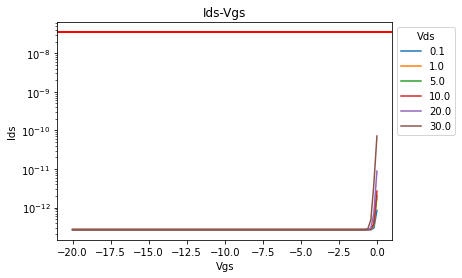

In [293]:
vgs_list = class_0_df['Vgs'].unique()
len(vgs_list)
vds_list = class_0_df['Vds'].unique()
len(vds_list)
for vds in vds_list:
    plt.plot(class_0_df.query('Vds=='+str(vds))['Vgs'], class_0_df.query('Vds=='+str(vds))['Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('Ids')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'r', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Ids-Vgs')

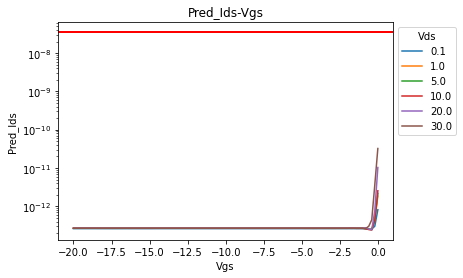

In [294]:
vgs_list = class_0_df['Vgs'].unique()
len(vgs_list)
vds_list = class_0_df['Vds'].unique()
len(vds_list)
for vds in vds_list:
    plt.plot(class_0_df.query('Vds=='+str(vds))['Vgs'], class_0_df.query('Vds=='+str(vds))['Pred_Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('Pred_Ids')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'r', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Pred_Ids-Vgs')

In [295]:
class_1_df.insert(3, 'Pred_Ids', class_1_pred.numpy())
print(class_1_df)

       Vds   Vgs           Ids      Pred_Ids   W   L   T        Vt       Drain
101    0.1   0.2  1.096300e-11  1.131922e-11  35  10  25  1.000042   -0.297515
102    0.1   0.4  1.932100e-10  2.058917e-10  35  10  25  1.000042   -0.227515
103    0.1   0.6  2.661500e-09  2.761486e-09  35  10  25  1.000042   -0.157515
104    0.1   0.8  1.311300e-08  1.296072e-08  35  10  25  1.000042   -0.087515
105    0.1   1.0  2.922100e-08  2.616460e-08  35  10  25  1.000042   -0.017515
...    ...   ...           ...           ...  ..  ..  ..       ...         ...
1201  30.0  19.2  5.308300e-04  5.376437e-04  35  10  25  0.599882  378.012408
1202  30.0  19.4  5.410700e-04  5.542579e-04  35  10  25  0.599882  399.012408
1203  30.0  19.6  5.513500e-04  5.578453e-04  35  10  25  0.599882  420.012408
1204  30.0  19.8  5.616900e-04  5.561214e-04  35  10  25  0.599882  441.012408
1205  30.0  20.0  5.720700e-04  5.702429e-04  35  10  25  0.599882  462.012408

[600 rows x 9 columns]


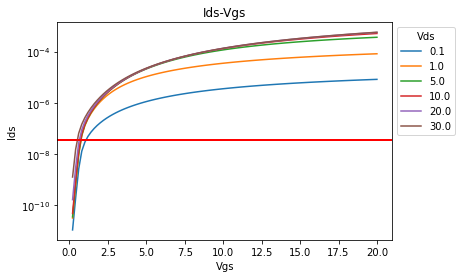

In [296]:
vgs_list = class_1_df['Vgs'].unique()
len(vgs_list)
vds_list = class_1_df['Vds'].unique()
len(vds_list)
for vds in vds_list:
    plt.plot(class_1_df.query('Vds=='+str(vds))['Vgs'], class_1_df.query('Vds=='+str(vds))['Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('Ids')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'r', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Ids-Vgs')

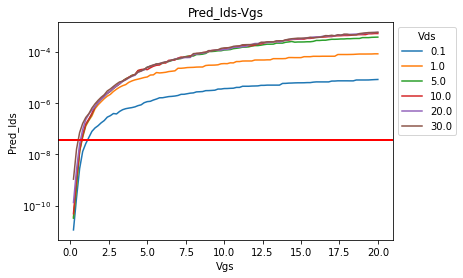

In [297]:
vgs_list = class_1_df['Vgs'].unique()
len(vgs_list)
vds_list = class_1_df['Vds'].unique()
len(vds_list)
for vds in vds_list:
    plt.plot(class_1_df.query('Vds=='+str(vds))['Vgs'], class_1_df.query('Vds=='+str(vds))['Pred_Ids'], label=vds)
    plt.xlabel('Vgs')
    plt.ylabel('Pred_Ids')
    plt.yscale('log')
    plt.axhline(y = 1e-8*W/L, color = 'r', linestyle = '-')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', title='Vds')
    plt.title('Pred_Ids-Vgs')

In [298]:
vgs_list

array([ 0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,
        2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,  4.4,
        4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,
        6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,  8.8,
        9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8, 11. ,
       11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. , 13.2,
       13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8, 15. , 15.2, 15.4,
       15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. , 17.2, 17.4, 17.6,
       17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. , 19.2, 19.4, 19.6, 19.8,
       20. ])

In [299]:
vds_list

array([ 0.1,  1. ,  5. , 10. , 20. , 30. ])

In [300]:
class_1_df.head()

,Vds,Vgs,Ids,Pred_Ids,W,L,T,Vt,Drain
101,0.1,0.2,1.096300e-11,1.131922e-11,35,10,25,1.000042,-0.297515
102,0.1,0.4,1.932100e-10,2.058917e-10,35,10,25,1.000042,-0.227515
103,0.1,0.6,2.661500e-09,2.761486e-09,35,10,25,1.000042,-0.157515
104,0.1,0.8,1.311300e-08,1.296072e-08,35,10,25,1.000042,-0.087515
105,0.1,1.0,2.922100e-08,2.616460e-08,35,10,25,1.000042,-0.017515


In [301]:
class_1_df.query('Vds=='+str(30.0))

,Vds,Vgs,Ids,Pred_Ids,W,L,T,Vt,Drain
1106,30.0,0.2,1.272500e-09,1.075219e-09,35,10,25,0.599882,-1616.987592
1107,30.0,0.4,1.528500e-08,1.602962e-08,35,10,25,0.599882,-1595.987592
1108,30.0,0.6,6.506500e-08,7.020826e-08,35,10,25,0.599882,-1574.987592
1109,30.0,0.8,1.475000e-07,1.596890e-07,35,10,25,0.599882,-1553.987592
1110,30.0,1.0,2.647200e-07,2.719828e-07,35,10,25,0.599882,-1532.987592
...,...,...,...,...,...,...,...,...,...
1201,30.0,19.2,5.308300e-04,5.376437e-04,35,10,25,0.599882,378.012408
1202,30.0,19.4,5.410700e-04,5.542579e-04,35,10,25,0.599882,399.012408
1203,30.0,19.6,5.513500e-04,5.578453e-04,35,10,25,0.599882,420.012408
1204,30.0,19.8,5.616900e-04,5.561214e-04,35,10,25,0.599882,441.012408
